# Preprocessing pipeline [dev]

The goal of this pipeline is to produce preprocessed data that is clean enough to be further analyzed in ERP or connectivity analyzes. This pipeline is semi-automatic; manual steps are not necessarily required, but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Steps
Considering the remarks [here](https://autoreject.github.io/faq.html#should-i-apply-ica-first-or-autoreject-first)


- bandpass filter 0.1-45Hz
- create fixed length epochs
- mark and reject bad data segments with [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013)
- fit ICA on cleaned data segments
- process components
- apply ICA
- run autoreject with more strict thresholds


## Install package requirements

Can be ignored if requirements are already installed.

In [ ]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

import mne
import pandas as pd
import numpy as np 
import autoreject
from eeg_preprocessing.utils.faster import faster_bad_epochs
from eeg_preprocessing.utils.events import get_events_from_raw
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
%matplotlib qt

In [2]:
from eeg_preprocessing.run_preprocessing import *

## Load raw data

In [3]:
# Set base path to EEG data
base_path = 'G:\TMS_rewiring/'

In [4]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

if not os.path.exists(interim_path):
    os.makedirs(interim_path)

In [5]:
# Choose a file using a FileChooser widget
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='G:\TMS_rewiring/', filename='', title='HTML(value='', layout=Layout(display='none'))', show_…

In [6]:
# Load selected file
raw_file_path = fc.selected
raw_id = Path(raw_file_path).stem
id_split = raw_id.split('_')
subject = id_split[0]
condition = id_split[1]
num_day = [x for x in id_split[-1] if x.isdigit()][0]

raw = mne.io.read_raw_brainvision(raw_file_path, preload=False, verbose=True)

Extracting parameters from G:\TMS_rewiring\Raw_data\24_L\Day1\EEG\24_L_Day1.vhdr...
Setting channel info structure...


In [ ]:
# Show PSD
raw.plot_psd()

## Event processing

In [9]:
resting_events, block_events = get_events_from_raw(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 77', 'Stimulus/S 78', 

D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_events['real_start_time'] = block_start_times
D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_events['end_time'] = events_df[events_df['event_id'] == 52]['start_time'].values
D:\weiglszonja\eeg-preprocessing\eeg_preprocessing\utils\events.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

## Cut raw data based on triggers


## I. Resting period

### Create folder for preprocessed files

In [7]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_rs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_rs')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

### Crop raw data

In [10]:
period = f'rs_{num_day}'
raw_rs_1 = concat_raws_from_events(resting_events[resting_events['event'] == period], raw)
raw_rs_1.info['fid'] = f'{subject}_{condition}_{period}'
print(raw_rs_1.info['fid'])

period = f'rs_{int(num_day)+1}'
raw_rs_2 = concat_raws_from_events(resting_events[resting_events['event'] == period], raw)
raw_rs_2.info['fid'] = f'{subject}_{condition}_{period}'
print(raw_rs_2.info['fid'])

24_L_rs_1
24_L_rs_2


### Visualize raw resting segment (optional)

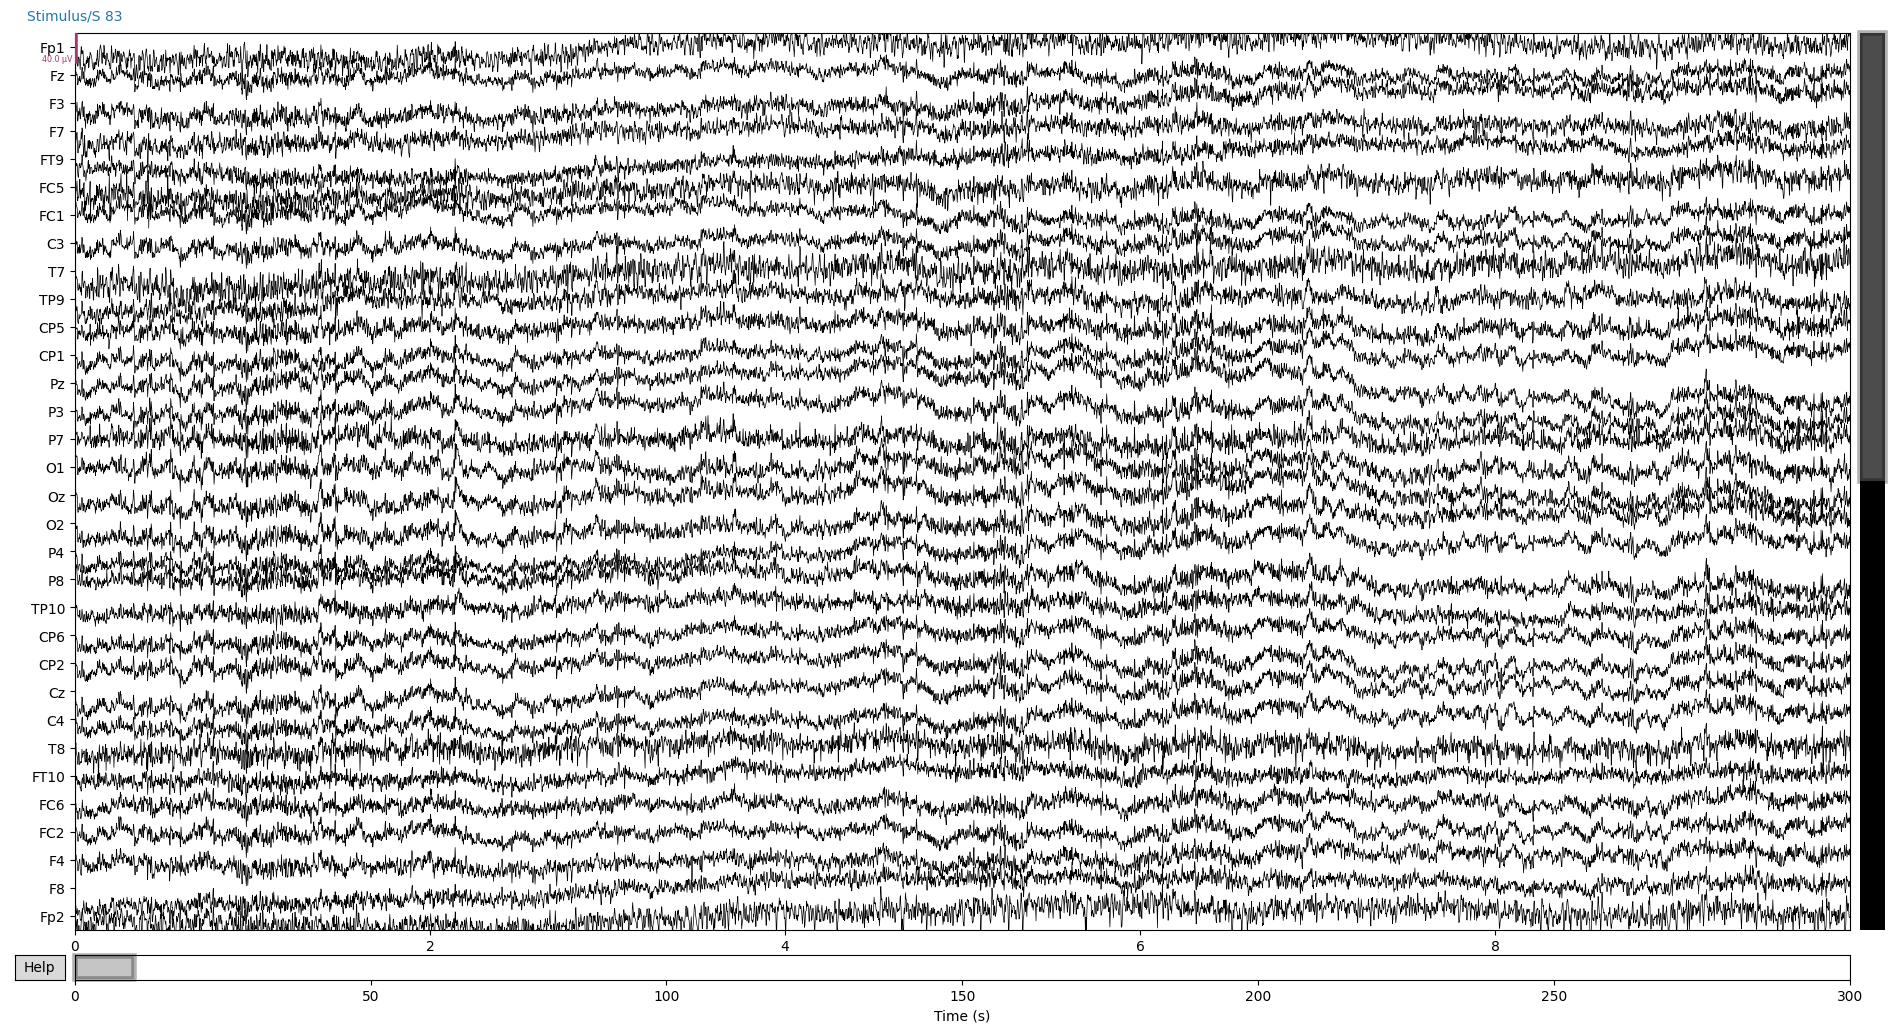

Channels marked as bad: none


In [11]:
# interactively scroll through data
raw_rs_1.plot(title=raw_rs_1.info['fid'],
              n_channels=32,
              remove_dc=True)

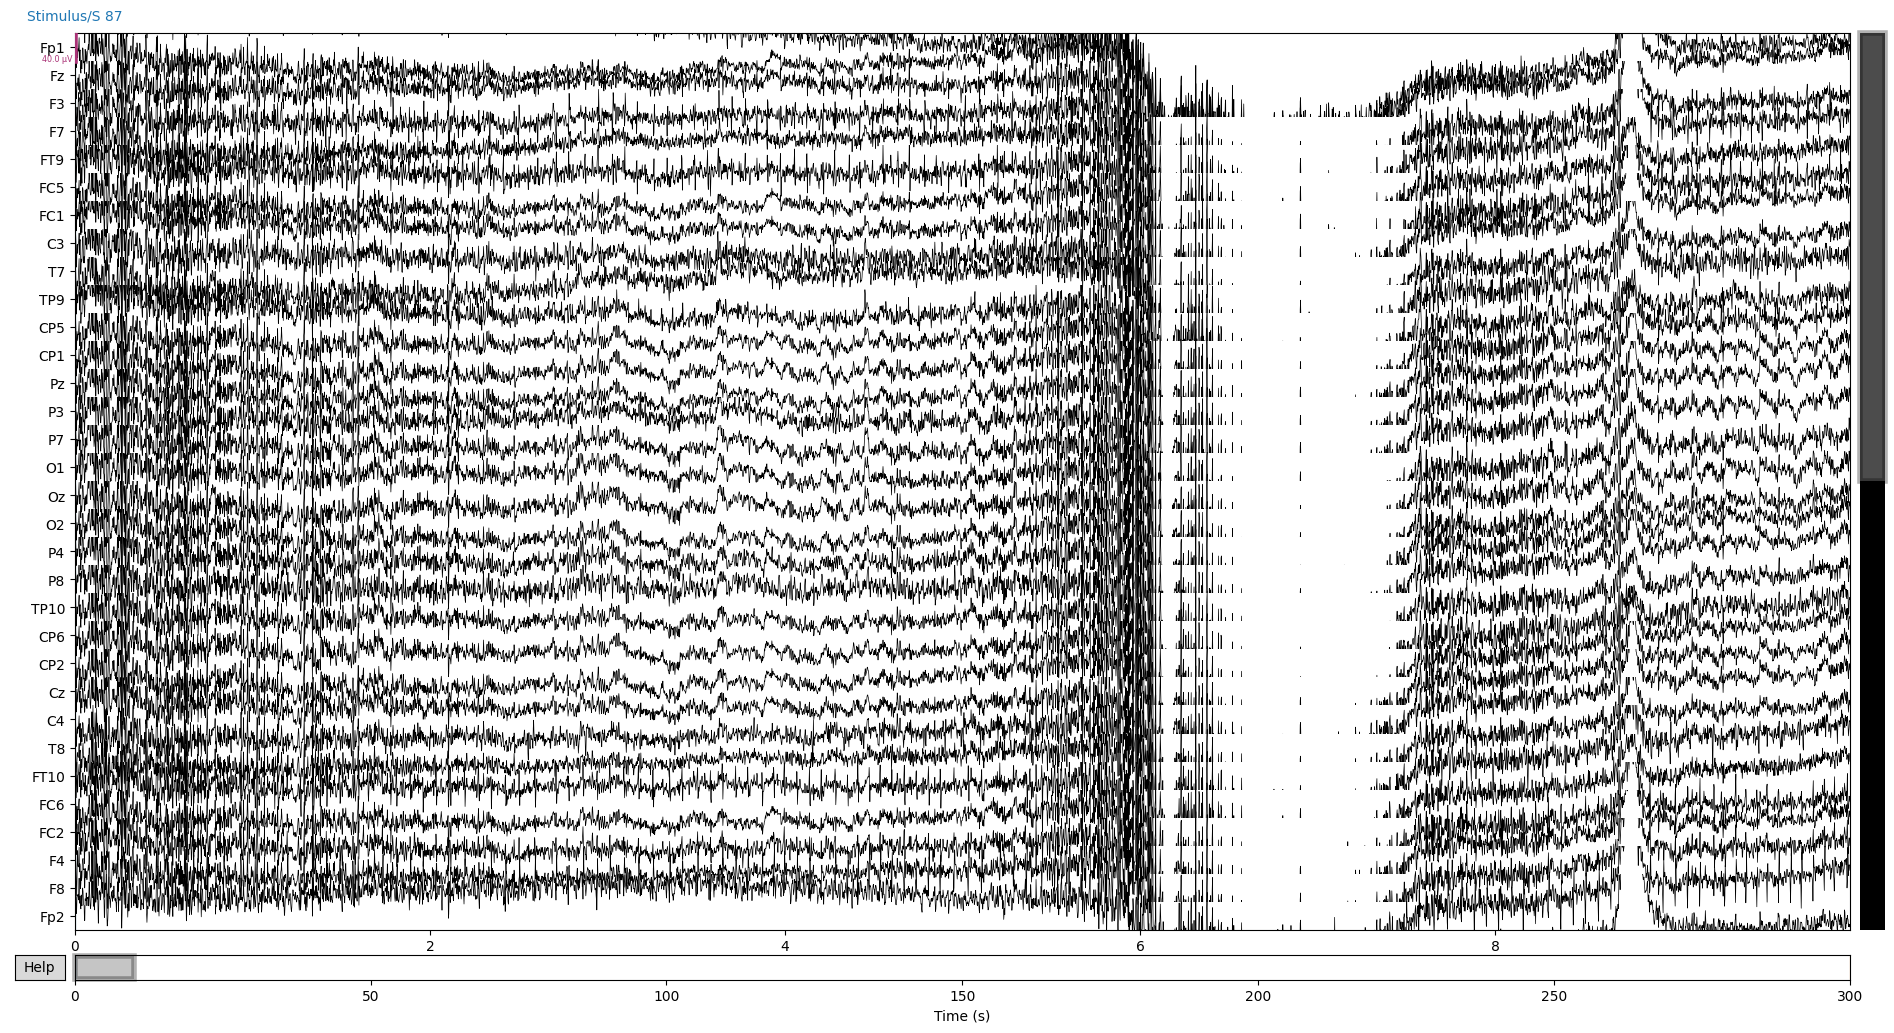

Channels marked as bad: none


In [12]:
# interactively scroll through data
raw_rs_2.plot(title=raw_rs_2.info['fid'],
              n_channels=32,
              remove_dc=True)

## Run preprocessing

### 1. Run ICA

In [ ]:
epochs_ica_rs_1 = run_ica(raw=raw_rs_1)

In [ ]:
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_ica_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_ica_rs_2 = run_ica(raw=raw_rs_2)

In [ ]:
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_ica_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 2. Run autoreject

In [ ]:
epochs_autoreject_rs_1 = run_autoreject(epochs_ica_rs_1)

In [ ]:
epochs_autoreject_rs_1.plot_drop_log()

In [ ]:
# save clean epochs
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_ica_rs_1

In [ ]:
epochs_autoreject_rs_2 = run_autoreject(epochs_ica_rs_2)

In [ ]:
epochs_autoreject_rs_2.plot_drop_log()

In [ ]:
# save clean epochs
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_ica_rs_2

### 3. Run ransac

In [ ]:
epochs_ransac_rs_1 = run_ransac(epochs_autoreject_rs_1)
# set average reference
epochs_ransac_rs_1.set_eeg_reference()

In [ ]:
# save clean epochs
fid = raw_rs_1.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs_1.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
epochs_ransac_rs_2 = run_ransac(epochs_autoreject_rs_2)
# set average reference
epochs_ransac_rs_2.set_eeg_reference()

In [ ]:
# save clean epochs
fid = raw_rs_2.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs_2.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_autoreject_rs_1, epochs_autoreject_rs_2

In [19]:
test = mne.read_epochs('G:/TMS_rewiring/preprocessed/L/epochs_rs/24_L_rs_2_ICA_autoreject_ransac-epo.fif.gz')

Reading G:/TMS_rewiring/preprocessed/L/epochs_rs/24_L_rs_2_ICA_autoreject_ransac-epo.fif.gz ...
    Found the data of interest:
        t =       0.00 ...     998.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated


In [25]:
# description!!! can it be a dict?
# when dropping epochs could use epochs_ar.copy().drop

## II. ASRT

In [ ]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_asrt')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_asrt')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

In [ ]:
raw_asrt_seqA = concat_raws_from_events(block_events[block_events['sequence'] == 'A'], raw)
#raw_asrt_seqB = concat_raws_from_events(block_events[block_events['sequence'] == 'B'], raw)

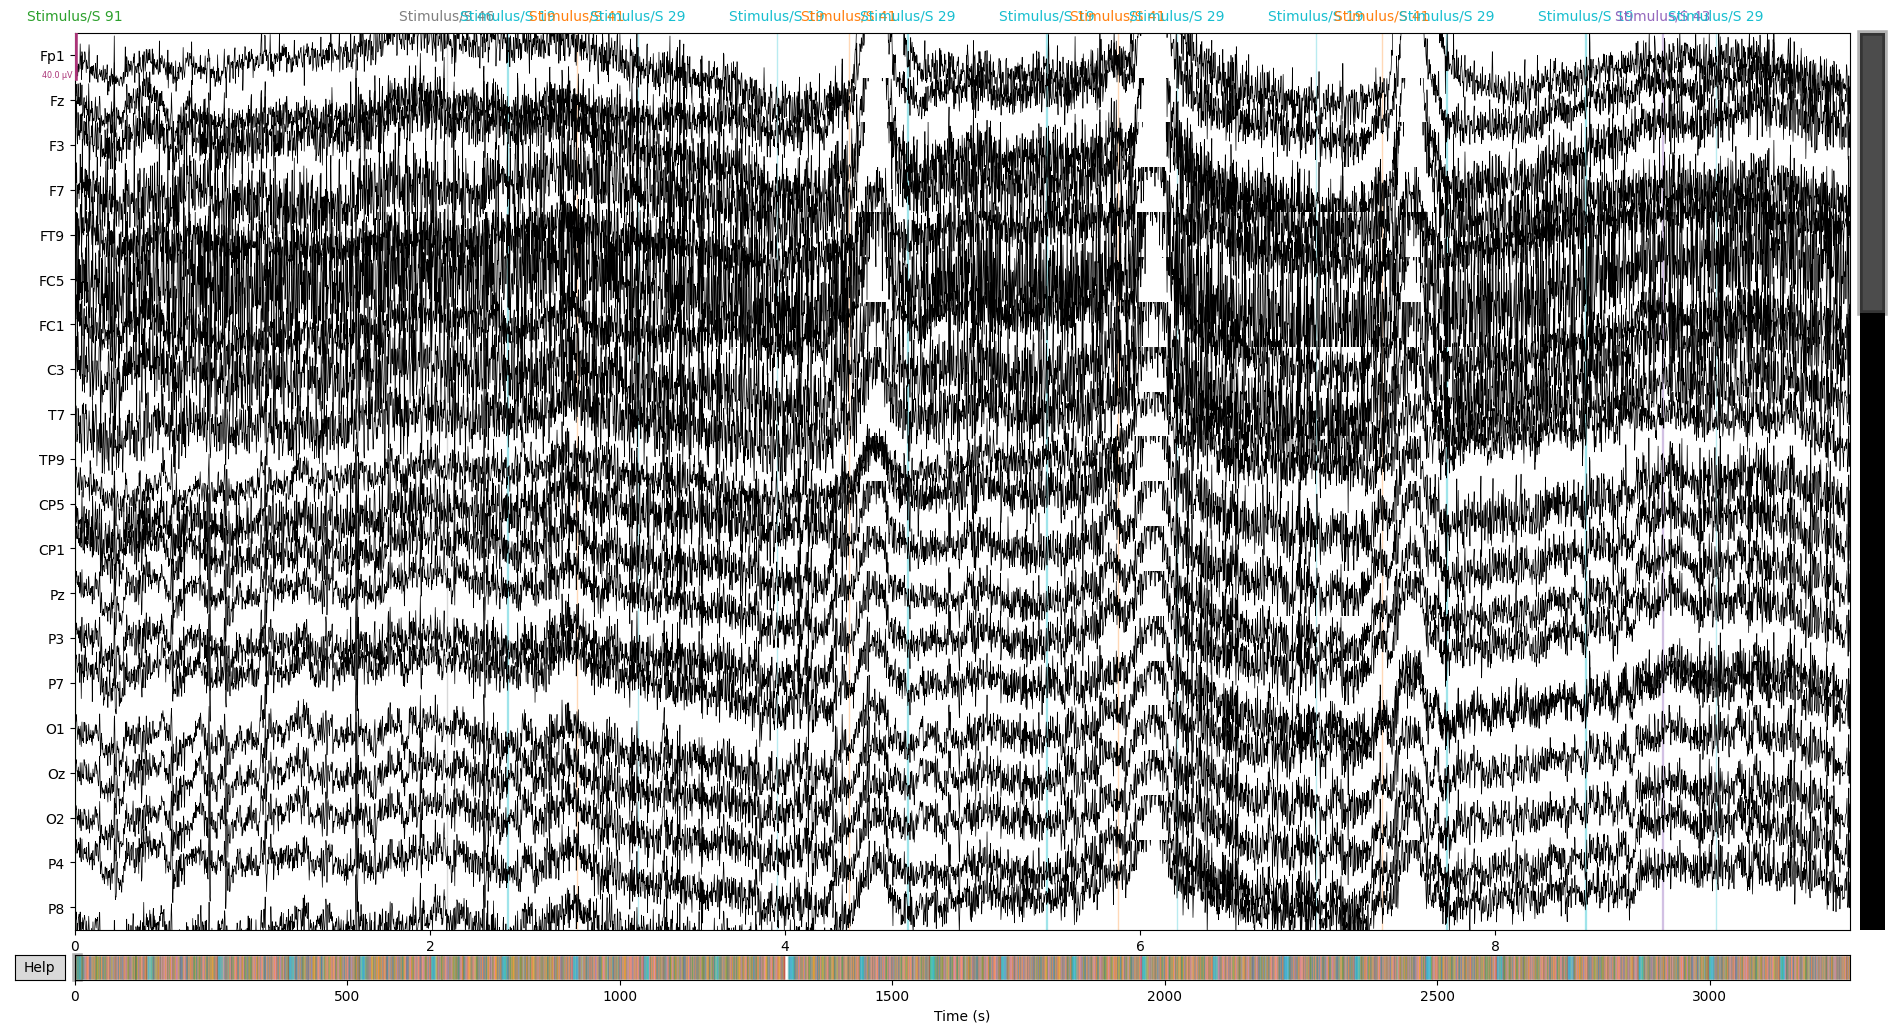

Channels marked as bad: none


In [32]:
raw_asrt_seqA.plot()

In [ ]:
epochs_ica = run_ica(raw=raw_asrt_seqA)

In [ ]:
fid = f'{subject}_{condition}_asrt_{num_day}'
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_ica.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
events = mne.make_fixed_length_events(raw_asrt_seqA,
                                  id=1,
                                  first_samp=True,
                                  duration=1.0,
                                  overlap=0.0)

start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ica.drop_log) if 'FASTER' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
epochs_autoreject = run_autoreject(epochs_ica)

In [ ]:
epochs_autoreject.plot_drop_log()

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_autoreject.drop_log) if 'AUTOREJECT' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
epochs_ransac = run_ransac(epochs_autoreject)

In [ ]:
epochs_ransac.plot(n_epochs=10)

In [ ]:
epochs_ransac.info['bad_channels_autoreject']

In [ ]:
epochs_ransac.info['bads'] = []
# epochs_ransac.info['rancac_bad_channels']

# set average reference
epochs_ransac.set_eeg_reference()

In [ ]:
raw_asrt_seqA.info['bad_channels'] = epochs_ransac.info['bads']

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
fname = f'{fid}_seqA_annotated'
postfix = '-raw.fif.gz'
raw_asrt_seqA.save(os.path.join(interim_raw_path, f'{fname}{postfix}'), overwrite=True)

In [ ]:
interim_raw_path